# Implementing a Variational Autoencoder (VAE) with TensorFlow for Image Generation Using the MNIST Dataset

## Steps to perform

'''
Step 1: Import the Necessary Libraries

Step 2: Load the MNIST Dataset

Step 3: Set Hyperparameters

Step 4: Define Model Architecture

Step 5: Define the Sampling Function

Step 6: Connect the Encoder and Decoder

Step 7: Define the Loss Function and Compile the Model

Step 8: Train the Model

Step 9: Generate a Manifold of Digits
'''

### Step 1: Import the Necessary Libraries

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

### Step 2: Load the MNIST Dataset

In [8]:
mnist = tf.keras.datasets.mnist
(x_train, _), (x_test, _) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

### Step 3: Set Hyperparameters
##### * Define the learning_rate, num_steps, and batch_size.
##### * learning_rate is the step size at each iteration while moving toward a minimum of a loss function.
##### * num_steps is the number of steps you want to train the model.
##### * batch_size is the number of samples that will be propagated through the network.

In [10]:
learning_rate = 0.001
num_steps = 100
batch_size = 64

### Step 4: Define VAE Model Architecture including encoder, decoder along with loss function

In [14]:
latent_dim=2 # Latent space dimension

# Define encoder part
encoder_inputs = tf.keras.Input(shape=(28,28))
x = tf.keras.layers.Flatten()(encoder_inputs)
x = tf.keras.layers.Dense(512,activation='relu')(x)
z_mean = tf.keras.layers.Dense(latent_dim)(x)
z_log_var = tf.keras.layers.Dense(latent_dim)(x)

# Define Decoder Part
latent_inputs  = tf.keras.Input(shape=(latent_dim,))
x = tf.keras.layers.Dense(512,activation='relu')(latent_inputs)
x = tf.keras.layers.Dense(784,activation='sigmoid')(x)
decoder_outputs = tf.keras.layers.Reshape((28,28))(x)

### Step 5: Define the Sampling Function

In [16]:
# Create a custom Keras layer for the sampling function used in the VAE.

class Sampling(tf.keras.layers.Layer):
    def call(self,inputs):
        z_mean,z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch,dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

### Step 6: Connect the Encoder and the Decoder

'''
Use keras functional API to connect the encoder and decoder parts of the VAE.encoder_outputs: The output of the Sampling layer, representing the latent variable 𝑧 z.
encoder model: Combines the input layer, Dense layers, and Sampling layer into a complete encoder model. decoder model: Takes the latent variable 𝑧 z as input and outputs the reconstructed image. vae_outputs: The final output of the VAE model, which is the reconstructed image. vae model: Combines the encoder and decoder into a single model that takes an image as input, encodes it into the latent space, and decodes it back to reconstruct the original ima
'''

In [17]:
encoder_outputs = Sampling()([z_mean, z_log_var])
encoder = tf.keras.Model(inputs=encoder_inputs, outputs=[z_mean, z_log_var, encoder_outputs])

decoder = tf.keras.Model(inputs=latent_inputs, outputs=decoder_outputs)
vae_outputs = decoder(encoder(encoder_inputs)[2])#####
vae = tf.keras.Model(inputs=encoder_inputs, outputs=vae_outputs)

### Step 7: Define the Loss Function and Compile the Model

In [18]:
# Define the VAE loss within the VAE model class
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def compute_loss(self, x):
        z_mean, z_log_var, z = self.encoder(x)
        reconstructed = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(x, reconstructed)
        )
        reconstruction_loss *= 28 * 28
        kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        kl_loss = tf.reduce_mean(kl_loss)
        kl_loss *= -0.5
        return reconstruction_loss + kl_loss

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            loss = self.compute_loss(data)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        return {'loss': loss}

# Instantiate and compile the VAE
vae = VAE(encoder, decoder)
vae.compile(optimizer='adam')

### Step 8: Train the Model

In [19]:
vae.fit(x_train, x_train, epochs=num_steps, batch_size=batch_size)

Epoch 1/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 181.3771
Epoch 2/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 162.4044
Epoch 3/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 158.8854
Epoch 4/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 156.4424
Epoch 5/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 154.7078
Epoch 6/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 153.4225
Epoch 7/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 152.4014
Epoch 8/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 151.5830
Epoch 9/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 150.8584
Epoch 10/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 150.2566
Epoch 11/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 149.7215
Epoch 12/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 149.1702
Epoch 13/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 148.7477
Epoch 14/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 148.2700
Epoch 15/100
9

### Step 9: Generate a Manifold of Digits

'''
Generate a manifold of digits by creating a latent space grid.
Feed these grid values into the decoder to produce images.
'''

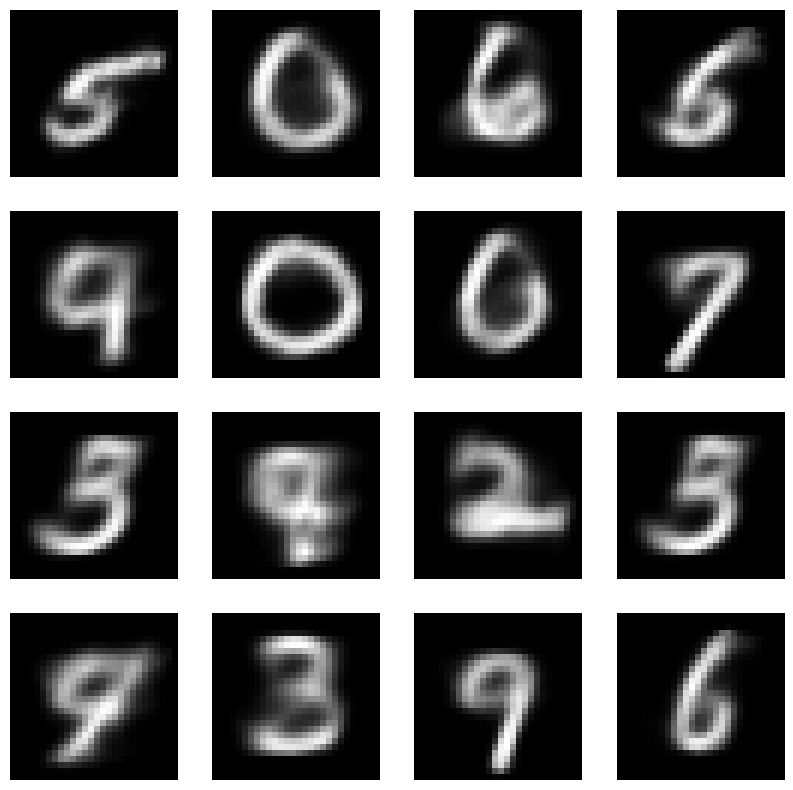

In [20]:
def generate_images(model, n_images):
    # Sample from the latent space
    random_latent_vectors = tf.random.normal(shape=(n_images, latent_dim))
    # Decode them to fake images
    generated_images = model.decoder(random_latent_vectors)
    generated_images = generated_images.numpy()

    # Calculate the number of rows needed in the subplot grid
    n_rows = int(np.ceil(n_images / 4))

    # Plot the generated images
    plt.figure(figsize=(10, 10))
    for i in range(n_images):
        plt.subplot(n_rows, 4, i + 1)
        plt.imshow(generated_images[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

# Generate and display images
generate_images(vae, 16)

### Conclusion

'''
In this demonstration, we have successfully implemented and trained a Variational Autoencoder (VAE) using TensorFlow to generate images based on the MNIST dataset. The process encompassed several critical steps, from importing necessary libraries to training the model, and finally, generating a manifold of digits.
'''